# MESQUAL 402: Folium KPI Visualization System

This notebook demonstrates how to visualize KPI data using MESQUAL's folium system. We'll explore how computed metrics and indicators can be mapped to interactive geographic visualizations with automatic coloring, legends, and multi-scenario analysis.

## Introduction

Building on the model data visualization from mesqual_401, this notebook focuses on visualizing computed KPIs (Key Performance Indicators). We'll cover:

1. **KPI Data Items**: How KPIs integrate with the folium visualization system
2. **KPI Collection Visualization**: Automatic mapping of KPI collections to maps
3. **Dynamic Coloring**: Using PropertyMapper.from_kpi_value() for data-driven styling
4. **Multi-Scenario KPI Maps**: Comparing KPIs across different scenarios
5. **KPI Filtering and Grouping**: Selective visualization of KPI subsets
6. **Interactive Features**: Tooltips, popups, and layer controls for KPI exploration

This approach enables sophisticated analysis of energy system performance metrics with geographic context.

## Setup

First, we need to set up the environment. If you are on Colab, the first cell will clone and install all dependencies. You will have to restart the session afterwards and continue with cell 2. If you are in a local environment, make sure that you have followed the Getting started steps in the README, so that mesqual and all requirements are installed.

In [1]:
import os

if "COLAB_RELEASE_TAG" in os.environ:
    import importlib.util

    def is_module_available(module_name):
        return importlib.util.find_spec(module_name) is not None

    if os.path.exists("mesqual-vanilla-studies") and is_module_available("mesqual"):
        print("✅ Environment already set up. Skipping installation.")
    else:
        print("🔧 Setting up Colab environment...")
        !git clone --recursive https://github.com/helgeesch/mesqual-vanilla-studies.git
        %cd mesqual-vanilla-studies/

        !pip install git+https://github.com/helgeesch/mesqual -U
        !pip install git+https://github.com/helgeesch/mesqual-pypsa -U
        !pip install git+https://github.com/helgeesch/captain-arro -U
        !pip install -r requirements.txt

        print('✅ Setup complete. 🔁 Restart the session, then skip this cell and continue with the next one.')
else:
    print("🖥️ Running locally. No setup needed.")

🖥️ Running locally. No setup needed.


In [2]:
import os

if "COLAB_RELEASE_TAG" in os.environ:
    import sys
    sys.path.append('/content/mesqual-vanilla-studies')
    os.chdir('/content/mesqual-vanilla-studies')
else:
    def setup_notebook_env():
        """Set working directory to repo root and ensure it's in sys.path."""
        import os
        import sys
        from pathlib import Path

        def find_repo_root(start_path: Path) -> Path:
            current = start_path.resolve()
            while current != current.parent:
                if (current / 'vanilla').exists():
                    return current
                current = current.parent
            raise FileNotFoundError(f"Repository root not found from: {start_path}")

        repo_root = find_repo_root(Path.cwd())
        os.chdir(repo_root)
        if str(repo_root) not in sys.path:
            sys.path.insert(0, str(repo_root))

    setup_notebook_env()

try:
    from mesqual import StudyManager
except ImportError:
    raise ImportError("❌ 'mesqual' not found. If you're running locally, make sure you've installed all dependencies as described in the README.")

if not os.path.isdir("studies"):
    raise RuntimeError(f"❌ 'studies' folder not found. Make sure your working directory is set to the mesqual-vanilla-studies root. Current working directory: {os.getcwd()}")

print("✅ Environment ready. Let's go!")

✅ Environment ready. Let's go!


In [3]:
import os
import folium
import pandas as pd
import numpy as np

from mesqual import StudyManager, kpis
from mesqual_pypsa import PyPSADataset
from mesqual.visualizations.folium_viz_system import (
    PropertyMapper, KPICollectionMapVisualizer,
    AreaGenerator, AreaFeatureResolver,
    CircleMarkerGenerator, CircleMarkerFeatureResolver,
    TextOverlayGenerator, TextOverlayFeatureResolver
)
from mesqual.visualizations.value_mapping_system import SegmentedContinuousColorscale
from mesqual.visualizations.folium_legend_system import ContinuousColorscaleLegend
from mesqual.utils.folium_utils.background_color import set_background_color_of_map
from mesqual.utils.plotly_utils.plotly_theme import colors
from vanilla.notebook_config import configure_clean_output_for_jupyter_notebook
from vanilla.conditional_renderer import ConditionalRenderer

# Register study-specific interpreters
from studies.study_01_intro_to_mesqual.src.study_specific_model_interpreters import (
    ControlAreaModelInterpreter, 
    ScigridDEBusModelInterpreter
)

PyPSADataset.register_interpreter(ControlAreaModelInterpreter)
PyPSADataset.register_interpreter(ScigridDEBusModelInterpreter)

configure_clean_output_for_jupyter_notebook()
renderer = ConditionalRenderer()

## Load Study Data and Setup KPIs

Let's load our study data and define comprehensive KPIs for visualization:

In [4]:
# Load the StudyManager with PyPSA Scigrid-DE network data
from studies.study_01_intro_to_mesqual.scripts.setup_study_manager import get_scigrid_de_study_manager
study = get_scigrid_de_study_manager()

print("Study scenarios:")
for dataset in study.scen.datasets:
    print(f"  📊 {dataset.name}")
    
print("\nComparisons:")
for dataset in study.comp.datasets:
    print(f"  🔄 {dataset.name}")

Study scenarios:
  📊 base
  📊 solar_150
  📊 solar_200
  📊 wind_150
  📊 wind_200

Comparisons:
  🔄 solar_150 vs base
  🔄 solar_200 vs base
  🔄 wind_150 vs base
  🔄 wind_200 vs base


In [22]:
# Clear any existing KPIs
study.scen.clear_kpi_collection_for_all_sub_datasets()
study.comp.clear_kpi_collection_for_all_sub_datasets()

# Get base dataset to access control areas
ds_base = study.scen.get_dataset('base')
control_areas = ds_base.fetch('control_areas').index.to_list()
generators = ds_base.fetch('generators').query("carrier.isin(['Gas', 'Hard Coal', 'Brown Coal'])").index.to_list()

# Define scenario KPIs
scenario_kpis = []

# 1. Market price KPIs for each control area
market_price_kpis = [
    kpis.FlagAggKPIFactory(
        'control_areas_t.vol_weighted_marginal_price',
        aggregation=kpis.aggregations.Mean,
        column_subset=area,
    )
    for area in control_areas
]
scenario_kpis.extend(market_price_kpis)

# 2. Generation capacity utilization KPIs
generation_kpis = [
    kpis.FlagAggKPIFactory(
        'generators_t.p',
        aggregation=kpis.aggregations.Mean,
        column_subset=g,
    )
    for g in generators
]
scenario_kpis.extend(generation_kpis)

# Define comparison KPIs (calculate changes between scenarios)
comparison_kpis = []

# Price changes
price_change_kpis = [
    kpis.ComparisonKPIFactory(
        factory,
        kpis.value_comparisons.Increase  # Absolute change
    )
    for factory in market_price_kpis
]
comparison_kpis.extend(price_change_kpis)

# Generation changes
generation_change_kpis = [
    kpis.ComparisonKPIFactory(
        factory,
        kpis.value_comparisons.Delta
    )
    for factory in generation_kpis
]
comparison_kpis.extend(generation_change_kpis)

# Add KPIs to datasets and compute
study.scen.add_kpis_to_all_sub_datasets(scenario_kpis)
study.comp.add_kpis_to_all_sub_datasets(comparison_kpis)

print(f"\nAdded {len(scenario_kpis)} scenario KPIs and {len(comparison_kpis)} comparison KPIs")

# Compute all KPIs
print("\nComputing scenario KPIs...")
study.scen.get_merged_kpi_collection().compute_all()

print("Computing comparison KPIs...")
study.comp.get_merged_kpi_collection().compute_all()

print("✅ All KPIs computed successfully!")


Added 253 scenario KPIs and 253 comparison KPIs

Computing scenario KPIs...
Computing comparison KPIs...
✅ All KPIs computed successfully!


## Explore KPI Structure

Let's examine the structure of our KPI collections to understand what we can visualize:

In [23]:
# Get KPI collections
scenario_kpi_collection = study.scen.get_merged_kpi_collection()
comparison_kpi_collection = study.comp.get_merged_kpi_collection()

print(f"Total scenario KPIs: {len(scenario_kpi_collection)}")
print(f"Total comparison KPIs: {len(comparison_kpi_collection)}")

# Show example KPIs
print("\nExample scenario KPIs:")
for i, kpi in enumerate(scenario_kpi_collection):
    print(f"  {i+1}. {kpi.name} = {kpi.value:.2f} {kpi.unit}")
    print(f"     Dataset: {kpi.dataset.name}")
    print(f"     Object: {getattr(kpi.attributes, 'object_name', 'N/A')}")
    if i == 2:
        break

print("\nExample comparison KPIs:")
for i, kpi in enumerate(comparison_kpi_collection):
    print(f"  {i+1}. {kpi.name} = {kpi.value:.2f} {kpi.unit}")
    print(f"     Dataset: {kpi.dataset.name}")
    print(f"     Object: {getattr(kpi.attributes, 'object_name', 'N/A')}")
    if i == 2:
        break

# Show KPI attributes for filtering
print("\nAvailable KPI attributes for filtering:")
sample_kpi = list(scenario_kpi_collection)[0]
for attr_name, attr_value in sample_kpi.attributes.as_dict(primitive_values=True).items():
    print(f"  {attr_name}: {attr_value}")

Total scenario KPIs: 1265
Total comparison KPIs: 2277

Example scenario KPIs:
  1. Mean generators_t.p (167 Gas) = 0.00 NaU
     Dataset: wind_150
     Object: 167 Gas
  2. Mean generators_t.p (422 Gas) = 0.00 NaU
     Dataset: solar_200
     Object: 422 Gas
  3. Mean generators_t.p (92 Gas) = 0.00 NaU
     Dataset: wind_200
     Object: 92 Gas

Example comparison KPIs:
  1. Mean generators_t.p (184_220kV Gas) Delta = 0.00 NaU
     Dataset: solar_200 vs base
     Object: 184_220kV Gas
  2. Mean generators_t.p (422 Gas) = 0.00 NaU
     Dataset: solar_200
     Object: 422 Gas
  3. Mean generators_t.p (167 Gas) = 0.00 NaU
     Dataset: wind_150
     Object: 167 Gas

Available KPI attributes for filtering:
  name: Mean generators_t.p (167 Gas)
  dataset: wind_150
  dataset_type: ScigridDEDataset
  unit: NaU
  base_unit: NaU
  flag: generators_t.p
  object_name: 167 Gas
  model_flag: generators
  aggregation: Mean
  column_subset: 167 Gas


## Part 1: Basic KPI Visualization

Let's start with a simple visualization of market prices across control areas for all scenarios:

Found 20 price KPIs


KPICollectionMapVisualizer: 100%|██████████| 20/20 [00:00<00:00, 471.78it/s]


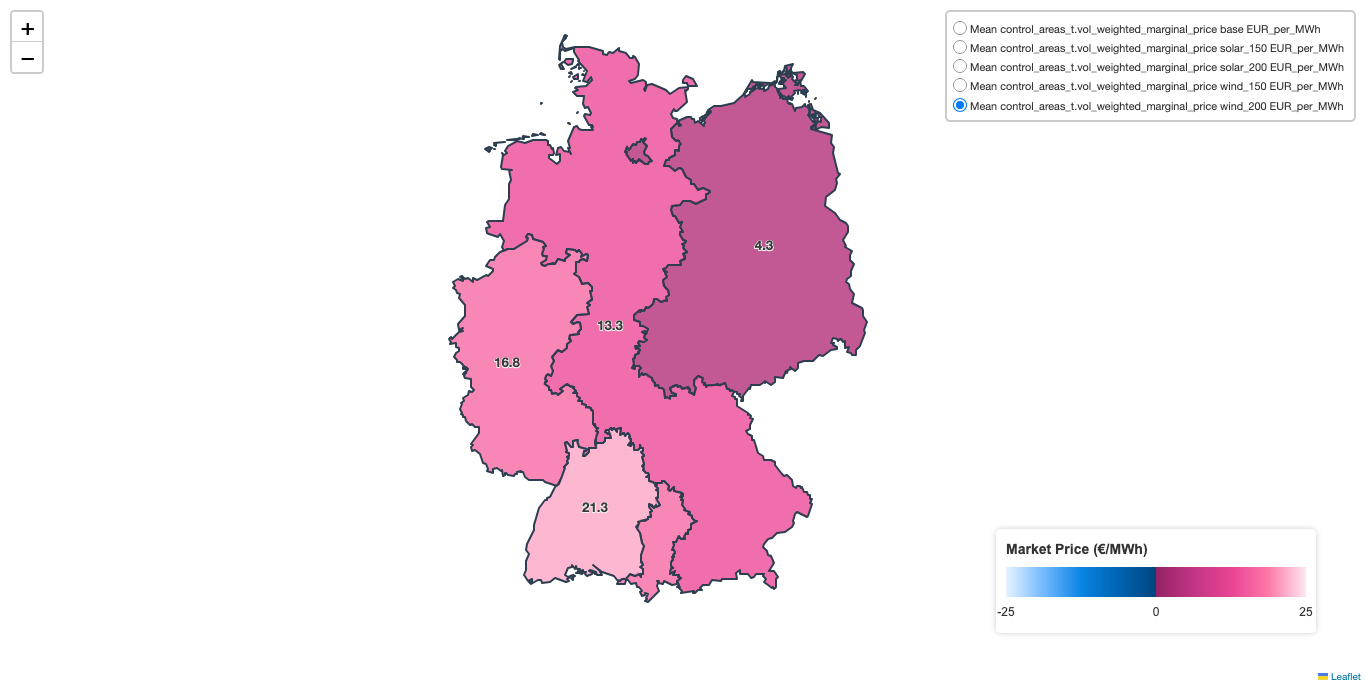

In [24]:
# Create colorscale for market prices
price_colorscale = SegmentedContinuousColorscale(
    segments={
        (-25, 0): colors.sequential.shades_of_blue,
        (0, 25): colors.sequential.shades_of_pink[::-1],
    },
    nan_fallback='#CCCCCC'
)

# Create map
m1 = folium.Map(
    location=[51, 11],
    zoom_start=6,
    tiles=None
)
m1 = set_background_color_of_map(m1, color='#ffffff')

# Add legend
ContinuousColorscaleLegend(
    mapping=price_colorscale,
    title="Market Price (€/MWh)",
    width=300,
    position={'bottom': 50, 'right': 50}
).add_to(m1)

# Create area generator with KPI-based coloring
price_area_generator = AreaGenerator(
    AreaFeatureResolver(
        fill_color=PropertyMapper.from_kpi_value(price_colorscale),
        fill_opacity=0.8,
        border_color=PropertyMapper.from_static_value('#2c3e50'),
        border_width=2,
        tooltip=True  # Auto-generates tooltip with KPI info
    )
)

# Filter KPIs to show only market prices
price_kpis = scenario_kpi_collection.get_filtered_kpi_collection_by_attributes(
    attr_query="flag.str.contains('price')",
)

print(f"Found {len(price_kpis)} price KPIs")

# Use KPICollectionMapVisualizer for automatic visualization
KPICollectionMapVisualizer(
    generators=[price_area_generator, TextOverlayGenerator()]
).generate_and_add_feature_groups_to_map(price_kpis, m1, show='last')

folium.LayerControl(collapsed=False).add_to(m1)
renderer.show_folium(m1)

## Part 2: Comparison Visualization

Now let's visualize price changes between scenarios using comparison KPIs:

Found 36 price change KPIs


KPICollectionMapVisualizer: 100%|██████████| 36/36 [00:01<00:00, 24.59it/s]


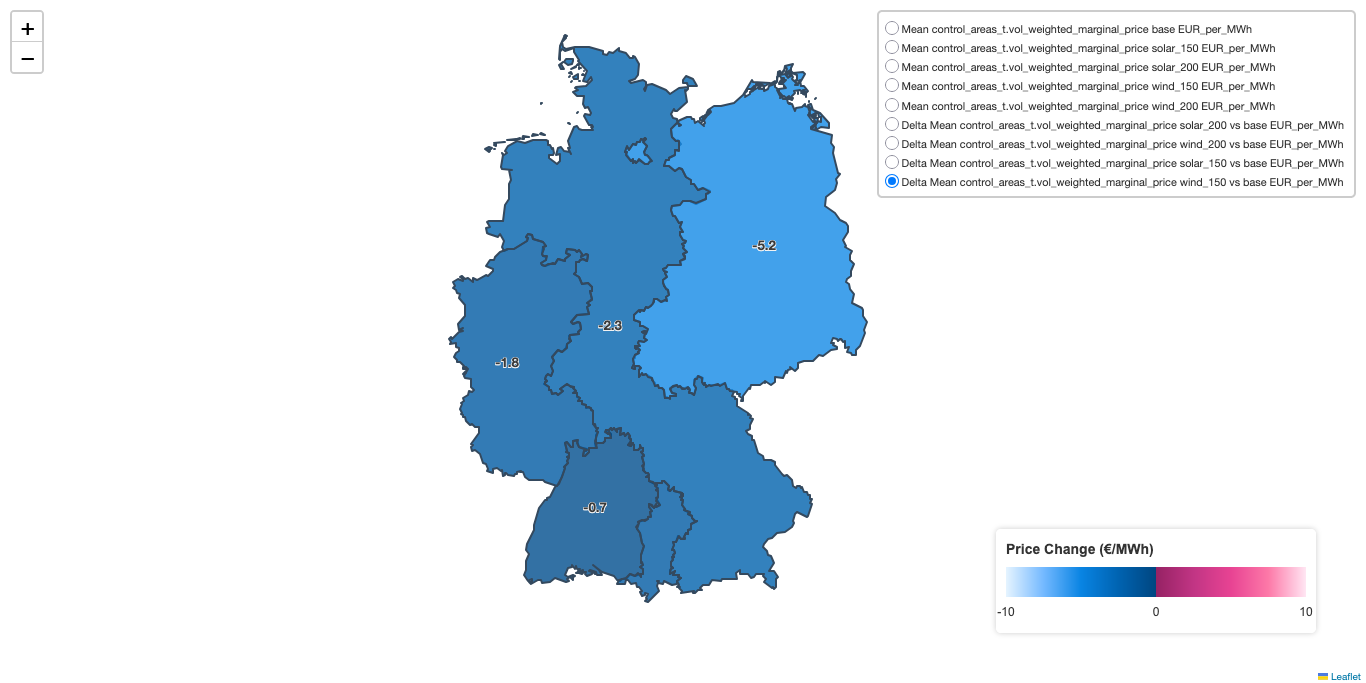

In [25]:
# Create diverging colorscale for price changes
price_change_colormap = SegmentedContinuousColorscale(
    segments={
        (-10, 0): colors.sequential.shades_of_blue,
        (0, 10): colors.sequential.shades_of_pink[::-1],
    },
    nan_fallback='#CCCCCC'
)

# Create comparison visualization map
m2 = folium.Map(
    location=[51, 11],
    zoom_start=6,
    tiles=None
)
m2 = set_background_color_of_map(m2, color='#ffffff')

# Add legend for price changes
ContinuousColorscaleLegend(
    mapping=price_change_colormap,
    title="Price Change (€/MWh)",
    width=300,
    position={'bottom': 50, 'right': 50}
).add_to(m2)

# Create area generator for price changes
price_change_generator = AreaGenerator(
    AreaFeatureResolver(
        fill_color=PropertyMapper.from_kpi_value(price_change_colormap),
        fill_opacity=0.8,
        border_color=PropertyMapper.from_static_value('#34495e'),
        border_width=2,
        tooltip=True
    )
)

# Filter comparison KPIs for price changes
price_change_kpis = comparison_kpi_collection.get_filtered_kpi_collection_by_attributes(
    attr_query="flag.str.contains('price')",
)

print(f"Found {len(price_change_kpis)} price change KPIs")

# Visualize price changes
KPICollectionMapVisualizer(
    generators=[price_change_generator, TextOverlayGenerator()]
).generate_and_add_feature_groups_to_map(price_change_kpis, m2, show='last')

folium.LayerControl(collapsed=False).add_to(m2)
renderer.show_folium(m2)

## Part 3: Multi-KPI Visualization

Let's create a comprehensive map showing multiple KPI types with layer controls:

KPICollectionMapVisualizer: 100%|██████████| 20/20 [00:00<00:00, 484.93it/s]
KPICollectionMapVisualizer: 0it [00:00, ?it/s]
KPICollectionMapVisualizer: 100%|██████████| 1245/1245 [00:15<00:00, 80.85it/s]


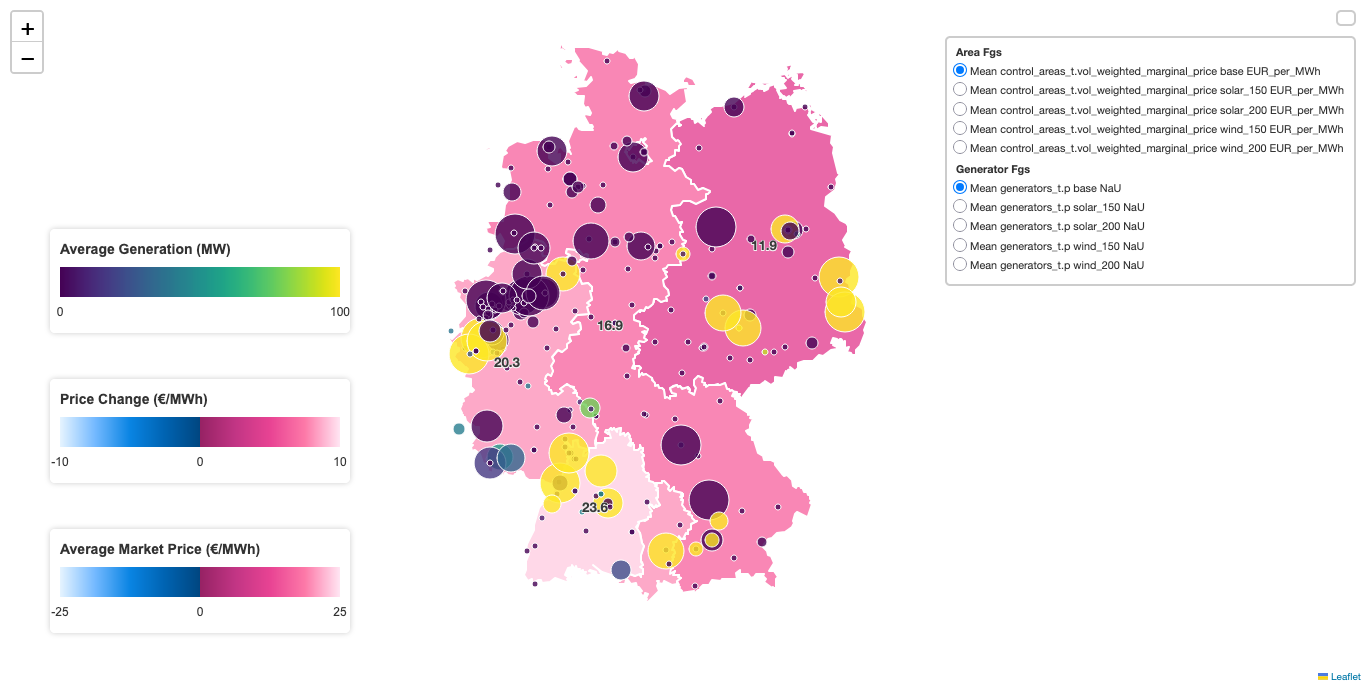

In [32]:
# Create comprehensive map with multiple KPI layers
m3 = folium.Map(
    location=[51, 11],
    zoom_start=6,
    tiles=None
)
m3 = set_background_color_of_map(m3, color='#ffffff')

# Define different colorscales for different KPI types
colorscales = {
    'price': price_colorscale,
    'change': price_change_colormap,
    'generation': SegmentedContinuousColorscale.single_segment_autoscale_factory_from_array(
        values=[0, 100],
        color_range='viridis',
    ),
}

# Add legends for each KPI type
legend_positions = [
    {'bottom': 50, 'left': 50},
    {'bottom': 200, 'left': 50},
    {'bottom': 350, 'left': 50}
]

ContinuousColorscaleLegend(
    mapping=colorscales['price'],
    title="Average Market Price (€/MWh)",
    width=280,
    position=legend_positions[0]
).add_to(m3)

ContinuousColorscaleLegend(
    mapping=colorscales['change'],
    title="Price Change (€/MWh)",
    width=280,
    position=legend_positions[1]
).add_to(m3)

ContinuousColorscaleLegend(
    mapping=colorscales['generation'],
    title="Average Generation (MW)",
    width=280,
    position=legend_positions[2]
).add_to(m3)

from shapely import Point
from mesqual.visualizations.folium_viz_system import VisualizableDataItem

# In this case, we don't have a "location" column ready in the generator model df, so we create the location on demand
def _get_location_of_generator(gen_data_item: VisualizableDataItem) -> Point:
    lat = gen_data_item.get_object_attribute('bus_y')
    lon = gen_data_item.get_object_attribute('bus_x')
    return Point([lon, lat])

# Create generators for different KPI types
generators = {
    'price': AreaGenerator(
        AreaFeatureResolver(
            fill_color=PropertyMapper.from_kpi_value(colorscales['price']),
            fill_opacity=0.8,
            border_width=2,
            tooltip=True
        )
    ),
    'generation': CircleMarkerGenerator(
        CircleMarkerFeatureResolver(
            fill_color=PropertyMapper.from_kpi_value(colorscales['generation']),
            # radius=PropertyMapper.from_kpi_value(lambda p: max(min(20, p/50), 3)),
            radius=PropertyMapper.from_item_attr('p_nom', lambda p: max(min(20, p/50), 3)),
            fill_opacity=0.8,
            border_width=1,
            tooltip=True,
            location=PropertyMapper(_get_location_of_generator)
        )
    ),
    'change': AreaGenerator(
        AreaFeatureResolver(
            fill_color=PropertyMapper.from_kpi_value(colorscales['change']),
            fill_opacity=0.8,
            border_width=2,
            tooltip=True
        )
    )
}

# Visualize market prices for scenarios
price_kpis = scenario_kpi_collection.get_filtered_kpi_collection_by_attributes(
    attr_query='flag.str.contains("price")'
)
price_fgs = KPICollectionMapVisualizer(
    generators=[generators['price'], TextOverlayGenerator()]
).generate_and_add_feature_groups_to_map(price_kpis, m3, show="none")

# Visualize price changes for comparisons
price_change_kpis = comparison_kpi_collection.get_filtered_kpi_collection_by_attributes(
    attr_query='flag.str.contains("price")',
    value_operation='Increase',
)
price_change_fgs = KPICollectionMapVisualizer(
    generators=[generators['change'], TextOverlayGenerator()]
).generate_and_add_feature_groups_to_map(price_change_kpis, m3, show='first')

# Visualize generation for scenarios
generation_kpis = scenario_kpi_collection.get_filtered_kpi_collection_by_attributes(
    attr_query='flag.str.contains("generators_t.p")',
)
generation_fgs = KPICollectionMapVisualizer(
    generators=[generators['generation'], TextOverlayGenerator()]
).generate_and_add_feature_groups_to_map(generation_kpis, m3, show='first')


folium.LayerControl(collapsed=False).add_to(m3)
from folium.plugins import GroupedLayerControl

GroupedLayerControl(
    groups={'Area Fgs': price_fgs + price_change_fgs, 'Generator Fgs': generation_fgs},
    exclusive_groups=True,
    collapsed=False,
).add_to(m3)

renderer.show_folium(m3)

## Summary: KPI Visualization System Architecture

Let's summarize the key components and patterns we've demonstrated:

### Key Components Demonstrated:
- 📊 KPIDataItem: Wraps KPI objects for visualization pipeline
- 🎨 PropertyMapper.from_kpi_value(): Maps KPI values to visual properties
- 🔍 KPI Collection Filtering: By attributes, scenarios, and types
- 🗺️ KPICollectionMapVisualizer: Automatic map generation
- 🎛️ Multi-layer visualization: Different KPI types on same map
- 📈 Custom styling: Based on KPI magnitude and significance

### Visualization Patterns:
- • Scenario Comparison: Side-by-side analysis of different cases
- • Change Analysis: Delta visualization with diverging colors
- • Multi-KPI Dashboards: Layer controls for different metrics
- • Significance Encoding: Opacity/border based on value magnitude
- • Interactive Features: Tooltips, popups, and layer controls

### Advanced Features:
- ✨ Automatic tooltip generation from KPI attributes
- 🎯 Regex-based KPI filtering for flexible selection
- 📏 Custom colorscales for different data ranges
- 🔄 Dynamic styling based on KPI properties
- 📊 Integration with MESQUAL's scenario comparison framework

## Conclusion

In this notebook, we've demonstrated MESQUAL's powerful KPI visualization system:

### Key Achievements:

1. **Automated KPI Mapping**: Direct integration between computed KPIs and geographic visualizations
2. **Multi-Scenario Analysis**: Simultaneous visualization of different scenarios and their comparisons
3. **Flexible Filtering**: Sophisticated KPI selection based on multiple criteria
4. **Advanced Styling**: Custom visual encoding based on KPI properties and significance
5. **Interactive Analysis**: Layer controls, tooltips, and popups for detailed exploration

### Architecture Benefits:

- **Unified Pipeline**: Same visualization system works for any KPI type
- **Automatic Integration**: KPIs automatically carry geographic context from their source datasets
- **Scalable Design**: Easily handles large numbers of KPIs across multiple scenarios
- **Customizable Styling**: PropertyMapper system enables any visual encoding pattern


### Practical Applications:

This visualization approach is particularly valuable for:
- **Scenario Impact Assessment**: Understanding regional effects of policy changes
- **Market Analysis**: Visualizing price patterns and market dynamics
- **Infrastructure Planning**: Identifying areas needing investment or attention
- **Stakeholder Communication**: Clear visual communication of complex analysis results